In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Обчислює теоретичну КДВ
import math
import cmath

# --- Глобальні змінні ---
R_vse = None
R_vseZ = None
R_vseZ_ML = None
DeltaTeta = None
DD = None
DDpd = None
Esum = None
DDPL1 = None
DDPL2 = None
DDparam = np.zeros(7)
km = 0
hpl0 = 0.0

m1  = 220   #1373
m10 = 20    #31
ik  = 10    #4.671897861
start_ML = 50
m1_ML=m1-start_ML
ML = False            # Без навчання (тільки демонастрація розрахунку КДВ)
Bicrystal = True      # False не працює!!!
Surface_Layer = True  # False не працює!!!
Polar_Sigma = True
Polar_Pi = False
Teta_in_Large = False

def Start():
    global psi, hpl, C, Lambda
    Lambda = 1.5405e-8
    psi = 0
    C = 1.0
    if Bicrystal is True:    hpl = 3.15e-4




# --- Функція GGG ---
def GGG():
    global a, d, ReChiRH, ImChiRH, ReChiIH, ImChiIH, ModChiRH, ModChiIH, ChiI0, ModChiI0
    a = 12.382e-8
    d = a / math.sqrt(4**2 + 4**2 + 4**2)
    ReChiRH = 14.5491e-6
    ImChiRH = 0.1587e-10
    ReChiIH = 3.8603e-6
    ImChiIH = 0.0352e-10
    ModChiRH = 14.5491e-6
    ModChiIH = 3.8603e-6
    ChiI0 = -4.2002e-6
    ModChiI0 = 4.2002e-6

# --- Функція YIG ---
def YIG():
    global apl, dpl, ReChiRHpl, ReChiIHpl, ModChiRHpl, ModChiIHpl, ChiI0pl, ModChiI0pl
    apl = 12.376e-8
    dpl = apl / math.sqrt(4**2 + 4**2 + 4**2)
    ReChiRHpl = 8.8269e-6
    ReChiIHpl = 0.9043e-6
    ModChiRHpl = 8.8269e-6
    ModChiIHpl = 0.9043e-6
    ChiI0pl = -2.1843e-6
    ModChiI0pl = 2.1843e-6

# --- Функція Profil ---
def Profil():
    global DD, Esum, km, dl, hpl0, DDPL1, DDPL2, DDparam

    # Параметри профілю деформації
    if (ML is False):
        Dmax1 = 0.01305
        D01 = 0.0017
        L1 = 5800e-8
        Rp1 = 3500e-8
        D02 = 0.004845
        L2 = 4000e-8
        Rp2 = -500e-8

        DDparam[0] = Dmax1
        DDparam[1] = D01
        DDparam[2] = L1
        DDparam[3] = Rp1
        DDparam[4] = D02
        DDparam[5] = L2
        DDparam[6] = Rp2
        print('  ***if (ML is False):****  ', DDparam[0], DDparam[1], DDparam[2], DDparam[3],DDparam[4])


    if (ML is True):
        Dmax1 = 0.01305
        D01 = 0.0017
        L1 = 5800e-8
        Rp1 = 3500e-8
        D02 = 0.004845
        L2 = 4000e-8
        Rp2 = -500e-8
        Dmax1 = DDparam[0]
        D01   = DDparam[1]
        L1    = DDparam[2]
        Rp1   = DDparam[3]
        D02   = DDparam[4]
        L2    = DDparam[5]
        Rp2   = DDparam[6]
        print('  ***if (ML is True):****  ', DDparam[0], DDparam[1], DDparam[2], DDparam[3],DDparam[4])


    Dmin = 0.0001
    dl = 100e-8

    s1 = (L1 - Rp1)**2 / np.log(Dmax1 / Dmin)
    s2 = Rp1**2 / np.log(Dmax1 / D01)
    s3 = L2 * (L2 - 2 * Rp2) / np.log(D02 / Dmin)
    ss = s2
    kk = 0

    DDPLk = Dmax1
    while DDPLk > Dmin:
        kk += 1
        z = dl * kk - dl / 2
        if z >= Rp1:
            ss = s1
        DDPLk = Dmax1 * np.exp(-(z - Rp1)**2 / ss)
        DDPLk += D02 * np.exp(Rp2**2 / s3) * np.exp(-(z - Rp2)**2 / s3)

    km = kk - 1
    L = km * dl
    hpl0 = hpl - L

    Dmax = 0
    ss = s1

    DD = np.zeros(km + 1)
    DDPL1 = np.zeros(km + 1)
    DDPL2 = np.zeros(km + 1)
    Esum = np.ones(km + 1)

    for k in range(1, km + 1):
        z = L - dl * k + dl / 2
        if z < Rp1:
            ss = s2
        DDPL1[k] = Dmax1 * np.exp(-(z - Rp1)**2 / ss)
        DDPL2[k] = D02 * np.exp(Rp2**2 / s3) * np.exp(-(z - Rp2)**2 / s3)
        DD[k] = DDPL1[k] + DDPL2[k]
        if Dmax < DD[k]:
            Dmax = DD[k]
        Esum[k] = 1
    #print (DD)
'''    # Збереження параметрів
    DDparam[0] = Dmax1
    DDparam[1] = D01
    DDparam[2] = L1 / 1e-8
    DDparam[3] = Rp1 / 1e-8
    DDparam[4] = D02
    DDparam[5] = L2 / 1e-8
    DDparam[6] = Rp2 / 1e-8'''


# --- Розрахунок когерентної складової ---
def RozrachKogerTT():
    global R_vse, DeltaTeta
    #m1  = 1373
    #m10 = 30
    #ik  = 4.671897861
    tb = math.asin(Lambda * math.sqrt(4**2 + 4**2 + 4**2) / (2 * a))
    gamma0 = math.sin(tb - psi)
    gammah = math.sin(tb + psi)
    b_as = gamma0 / abs(gammah)
    cmplxi = complex(0, 1)

    xhp0 = complex(ReChiRH, ReChiIH)
    xhn0 = complex(ReChiRH, ReChiIH)
    xhp = complex(ReChiRHpl, ReChiIHpl)
    xhn = complex(ReChiRHpl, ReChiIHpl)
    x0i0 = ChiI0
    x0i = ChiI0pl


    tb = math.asin(Lambda * math.sqrt(4**2 + 4**2 + 4**2) / (2 * a))
    #ik = 4.671897861
    apl_a = (apl - a) / a
    tan_tb = math.tan(tb)
    odpl = math.ceil(apl_a * tan_tb / (ik / 3600 * math.pi / 180))
    DD0 = odpl * (ik / 3600 * math.pi / 180) / tan_tb
    DDpd = (DD[:km + 1] + 1) * (DD0 + 1) - 1
    #print ('DD0=',DD0)

    '''if not Surface_Layer:
        hpl0 = hpl
    #if Surface_Layer is not True: hpl0=hpl
    #print ('hpl0=',hpl0)
    '''

    eta00 = math.pi * x0i0 * (1 + b_as) / (Lambda * gamma0)
    eta0 = math.pi * x0i * (1 + b_as) / (Lambda * gamma0)

    TetaMin = -m10 * ik
    Hteta = math.pi / (3600 * 180)
    DeltaTeta = np.array([TetaMin + i * ik for i in range(m1 + 1)])
    R_vse = np.zeros(m1 + 1)

    for i in range(m1 + 1):
        dtheta = DeltaTeta[i] * Hteta
        eta0pd = -(eta00 * cmplxi + 2 * math.pi * b_as * math.sin(2 * tb) * dtheta / (Lambda * gamma0))
        eta_val = -(eta0 * cmplxi + 2 * math.pi * b_as * math.sin(2 * tb) * dtheta / (Lambda * gamma0))

        sigmasp0 = math.pi * xhp0 * C / (Lambda * cmath.sqrt(gamma0 * gammah))
        sigmasn0 = math.pi * xhn0 * C / (Lambda * cmath.sqrt(gamma0 * gammah))
        sigmasp = math.pi * xhp * C / (Lambda * cmath.sqrt(gamma0 * gammah))
        sigmasn = math.pi * xhn * C / (Lambda * cmath.sqrt(gamma0 * gammah))

        sqs = cmath.sqrt(eta0pd**2 - 4 * sigmasp0 * sigmasn0)
        if sqs.imag <= 0:
            sqs = -sqs
        if eta00 <= 0:
            sqs = -sqs
        As = -(eta0pd + sqs) / (2 * sigmasn0)

        if Bicrystal is True:
           YYs0 = 2 * math.pi / d * DD0
           YYs0 = eta_val + YYs0
           sqs = cmath.sqrt((YYs0 / 2) * (YYs0 / 2) - sigmasp * sigmasn)
           if sqs.imag <= 0:
              sqs = -sqs
           if eta0 <= 0:
              sqs = -sqs
           ssigma = sqs / cmplxi
           x2s = -(YYs0 / 2 + sqs) / sigmasn
           x1s = -(YYs0 / 2 - sqs) / sigmasn
           x3s = (x1s - As) / (x2s - As)
           expcs = cmath.exp(-2 * ssigma * hpl0)
           As = (x1s - x2s * x3s * expcs) / (1 - x3s * expcs)

        if Surface_Layer is True:
            for k in range(1, km + 1):
                YYs_k = math.pi / Lambda / gamma0 * DDpd[k] * b_as * (
                math.cos(psi)**2 * math.tan(tb) + math.sin(psi) * math.cos(psi)) * 2 * math.sin(2 * tb)
                YYs_k = eta_val + YYs_k
                sqs = cmath.sqrt((YYs_k / 2)**2 - sigmasp * sigmasn * Esum[k]**2)
                if sqs.imag <= 0:
                    sqs = -sqs
                if eta0 <= 0:
                    sqs = -sqs
                ssigma = sqs / cmplxi
                x2s = -(YYs_k / 2 + sqs) / (sigmasn * Esum[k])
                x1s = -(YYs_k / 2 - sqs) / (sigmasn * Esum[k])
                x3s = (x1s - As) / (x2s - As)
                expcs = cmath.exp(-2 * ssigma * 400e-8)
                As = (x1s - x2s * x3s * expcs) / (1 - x3s * expcs)

        R_vse[i] = abs(xhp0 / xhn0) * abs(As)**2

# --- Згортка ---
def Zgortka():
    global R_vseZ, R_vseZ_ML
    w = 25
    A = 10000
    Ymin = 0.0001
    y0 = 0.
    xc = 0.
    #ik = 4.671897861
    #m10 = 30
    #m1 = 1373

    log_part = math.log((Ymin - y0) / ((A / w) * math.sqrt(2 * math.log(4) / math.pi)))
    Xmin = xc + math.sqrt(-w ** 2 / (2 * math.log(4)) * log_part)
    m10z = int(abs(Xmin) / ik)
    MZ = m10z * 2

    PO = np.zeros(MZ + 1)
    TetaMinz = -m10z * ik
    for i in range(MZ + 1):
        x = TetaMinz + i * ik
        PO[i] = y0 + (A / w * math.sqrt(2 * math.log(4) / math.pi) * math.exp(-2 * (x - xc) ** 2 * math.log(4) / w ** 2))
    PO /= np.sum(PO)

    POO = np.zeros(MZ + 2 * m10 + 1)
    for i in range(MZ, -1, -1):
        izg = i + (m10 - m10z)
        if izg < len(POO):
            POO[izg] = PO[i]

    R_vseZ = np.zeros(m1 + 1)
    for j in range(m1 + 1):
        for i in range(MZ + (m10 - m10z) + 1):
            idx = j - i + m10
            if 0 <= idx < len(R_vse):
                R_vseZ[j] += R_vse[idx] * POO[i]

    R_vseZ_ML = np.asarray(R_vseZ)[start_ML:m1]
# --- Вивід результатів ---
    # Побудова графіків Series2, Series3, Series4
def plot_profils():
    L=dl*km
    x_vals = [(L - dl * k + dl / 2) / 1e-8 for k in range(1, km + 1)]
    plt.figure(figsize=(5, 3))
    plt.plot(x_vals, DD[1:km + 1], label='DD (Total)', color='red')
    plt.plot(x_vals, DDPL1[1:km + 1], label='DDPL1 (Asymmetric Gaussian)', linestyle='--')
    plt.plot(x_vals, DDPL2[1:km + 1], label='DDPL2 (Decaying Gaussian)', linestyle=':')
    plt.xlabel('z (Å)')
    plt.ylabel('Deformation profile')
    plt.title('Deformation Profile Components')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


#def plot_results():
def plot_results(xlim=None, ylim=None, log_scale=True):

    plt.figure(figsize=(5, 3))
    plt.plot(DeltaTeta, R_vse, label='R_vse (Takagi-Taupin)', color='darkgreen')
    plt.plot(DeltaTeta, R_vseZ, label='R_vseZ (Convolved)', color='blue')
    plt.xlabel('Δθ (arcsec)')
    plt.ylabel('R (intensity)')
    plt.title('Scattering from Bicrystal (psi=1)')
    plt.grid(True)
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if log_scale:
        plt.yscale('log')
    plt.xlim(-300, 2100)
    plt.tight_layout()
    plt.show()

# --- Основна програма ---
def main_XRD():
    Start()
    GGG()
    if Surface_Layer:
        YIG()
        Profil()  # hpl0 = hpl - L (розрахунок деформаційного профілю)
    else:
        global hpl0
        hpl0 = hpl  # немає деформаційного шару => вся товщина = недеформована частина
    RozrachKogerTT()
    Zgortka()
 #   plot_profils()
 #   plot_results()

if __name__ == '__main__':
    main_XRD()


  ***if (ML is False):****   0.01305 0.0017 5.8e-05 3.5e-05 0.004845


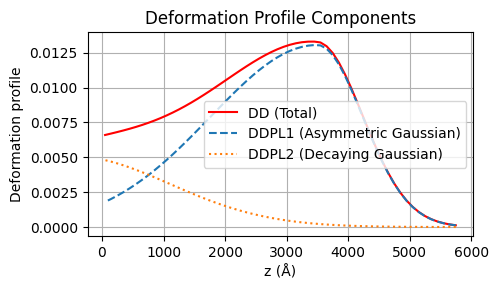

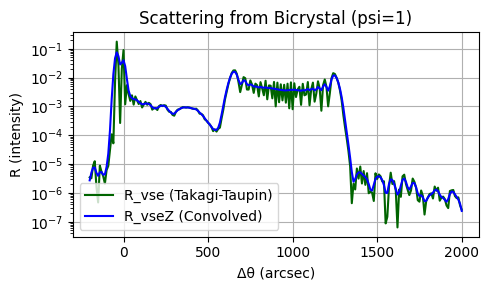

In [16]:
# Вивід графіків (профіль і КДВ)
plot_profils()
plot_results()

In [17]:
x = torch.linspace(0, m1_ML-1, m1_ML)  # 220 точок # Функція torch.linspace(start, end, steps) у PyTorch створює тензор із рівновіддалених чисел між start і end.
x

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14

In [18]:
# Фіксовані x-координати

x = torch.linspace(0, m1_ML-1, m1_ML)  # 220 точок # Функція torch.linspace(start, end, steps) у PyTorch створює тензор із рівновіддалених чисел між start і end.
#print(x)
def generate_parabola_dataset(n_samples):   #Функція для генерації датасету парабол
    X = []  # параметри a, b, c
    Y = []  # відповідні y-значення
    for i in range(n_samples):   # Для кожного прикладу випадково вибираються коефіцієнти a, b, c параболи.
        DDparam[0] = np.random.uniform(0.0125, 0.0135)    #a = np.random.uniform(-10.0, 10.0)
        DDparam[1] = np.random.uniform(0.001, 0.01)     #b = np.random.uniform(-10.0, 10.0)
        DDparam[4] = np.random.uniform(0.001, 0.01)    #c = np.random.uniform(-10.0, 10.0)
        #print("   Перед main_XRD ",DDparam[0],DDparam[1],DDparam[4])
        global ML
        ML=True
        main_XRD()               #y = a * x**2 + b * x + c

#        print('   Після main_XRD****  ', i, ' ---- ', DDparam[0], DDparam[1], DDparam[2], DDparam[3], DDparam[4], DDparam[5], DDparam[6])
        X.append([DDparam[0], DDparam[1], DDparam[4]])   #X.append([a, b, c])   # накопичує коефіцієнти (розмірність буде [n_samples, 3]).
        y=torch.tensor(R_vseZ_ML)
        Y.append(y)           # накопичує масив значень параболи (розмірність [n_samples, 100]).
    # Перетворення у PyTorch тензори:
    X = torch.tensor(X, dtype=torch.float32)  # X → тензор коефіцієнтів.  # Функція torch.tensor() створює тензор PyTorch із наданих даних (списку, numpy-масиву чи іншого тензора).
 #   print('  ***main_XRD****!!!!!!+++++X  \n', X)                                                                               # Всі тензори, що "складаються", повинні мати однакову форму.
    Y = torch.stack(Y)                        # Y → стек з усіх масивів y-значень  # Функція torch.stack(tensors, dim=0) об’єднує кілька тензорів в один, додаючи нову вісь (новий вимір).
  #  print('  ***main_XRD****!!!!!!+++++Y  \n', Y)                                                                               # Всі тензори, що "складаються", повинні мати однакову форму.
    return X, Y

In [19]:
generate_parabola_dataset(1)

  ***if (ML is True):****   0.012864252733077909 0.004974286210412147 5.8e-05 3.5e-05 0.008621793066132422


(tensor([[0.0129, 0.0050, 0.0086]]),
 tensor([[7.0231e-04, 7.2040e-04, 7.2653e-04, 7.0503e-04, 6.9590e-04, 6.9662e-04,
          6.7818e-04, 6.6331e-04, 6.8182e-04, 7.0943e-04, 7.2235e-04, 7.4047e-04,
          7.6976e-04, 7.7284e-04, 7.3372e-04, 6.8861e-04, 6.6546e-04, 6.5092e-04,
          6.3445e-04, 6.3122e-04, 6.4406e-04, 6.5056e-04, 6.4298e-04, 6.4023e-04,
          6.4919e-04, 6.4648e-04, 6.1372e-04, 5.6974e-04, 5.4923e-04, 5.6179e-04,
          5.8960e-04, 6.1764e-04, 6.4645e-04, 6.7325e-04, 6.8059e-04, 6.5632e-04,
          6.1555e-04, 5.9161e-04, 6.0485e-04, 6.4573e-04, 6.8903e-04, 7.1768e-04,
          7.2878e-04, 7.2266e-04, 6.9537e-04, 6.4675e-04, 5.9117e-04, 5.5112e-04,
          5.3945e-04, 5.4925e-04, 5.5946e-04, 5.5245e-04, 5.3026e-04, 5.0965e-04,
          5.0388e-04, 5.2150e-04, 5.6538e-04, 6.2493e-04, 6.8397e-04, 7.3509e-04,
          7.7660e-04, 7.9746e-04, 7.7961e-04, 7.1837e-04, 6.3106e-04, 5.4665e-04,
          4.9525e-04, 5.0288e-04, 5.8012e-04, 7.0890e-04, 8.4

In [20]:
# Виклик функції (Згенерує 100 000 парабол з випадковими коефіцієнтами.)
X, Y = generate_parabola_dataset(1)  # 100k парабол
#print('  ***X,Y****  ', X[0,0],  X[0,1],  X[0,2])
# Перевірка розмірностей
# print(X.shape)  # -> torch.Size([10000, 3])    для кожної з 100k парабол зберігається трійка (a, b, c).
# print(Y.shape)  # -> torch.Size([10000, 100])  для кожної параболи зберігається вектор із 100 значень y (відповідно до 100 x-координат).
X, Y

  ***if (ML is True):****   0.013113726998944461 0.001350649904724 5.8e-05 3.5e-05 0.005830854404973652


(tensor([[0.0131, 0.0014, 0.0058]]),
 tensor([[7.9139e-04, 8.7978e-04, 9.4348e-04, 9.5130e-04, 9.2408e-04, 8.6682e-04,
          7.8001e-04, 6.8994e-04, 6.1488e-04, 5.4742e-04, 4.9258e-04, 4.6633e-04,
          4.6251e-04, 4.5872e-04, 4.4158e-04, 4.2272e-04, 4.1677e-04, 4.1306e-04,
          4.1578e-04, 4.4728e-04, 4.8985e-04, 5.1881e-04, 5.4224e-04, 5.7914e-04,
          6.2651e-04, 6.5187e-04, 6.5075e-04, 6.4429e-04, 6.4757e-04, 6.5418e-04,
          6.6305e-04, 6.9238e-04, 7.4908e-04, 8.2231e-04, 9.4577e-04, 1.3029e-03,
          2.2941e-03, 4.5277e-03, 8.5910e-03, 1.4236e-02, 1.9376e-02, 2.0660e-02,
          1.6540e-02, 1.0356e-02, 7.6053e-03, 8.6410e-03, 8.7110e-03, 6.7387e-03,
          5.9312e-03, 6.1062e-03, 5.4440e-03, 5.0032e-03, 4.9105e-03, 4.5596e-03,
          4.4676e-03, 4.3113e-03, 4.2398e-03, 4.2097e-03, 4.1406e-03, 4.2326e-03,
          4.1522e-03, 4.2181e-03, 4.1014e-03, 4.0237e-03, 3.8579e-03, 3.7028e-03,
          3.5552e-03, 3.4747e-03, 3.4068e-03, 3.4916e-03, 3.4

In [21]:
print(X)
print(Y)

tensor([[0.0131, 0.0014, 0.0058]])
tensor([[7.9139e-04, 8.7978e-04, 9.4348e-04, 9.5130e-04, 9.2408e-04, 8.6682e-04,
         7.8001e-04, 6.8994e-04, 6.1488e-04, 5.4742e-04, 4.9258e-04, 4.6633e-04,
         4.6251e-04, 4.5872e-04, 4.4158e-04, 4.2272e-04, 4.1677e-04, 4.1306e-04,
         4.1578e-04, 4.4728e-04, 4.8985e-04, 5.1881e-04, 5.4224e-04, 5.7914e-04,
         6.2651e-04, 6.5187e-04, 6.5075e-04, 6.4429e-04, 6.4757e-04, 6.5418e-04,
         6.6305e-04, 6.9238e-04, 7.4908e-04, 8.2231e-04, 9.4577e-04, 1.3029e-03,
         2.2941e-03, 4.5277e-03, 8.5910e-03, 1.4236e-02, 1.9376e-02, 2.0660e-02,
         1.6540e-02, 1.0356e-02, 7.6053e-03, 8.6410e-03, 8.7110e-03, 6.7387e-03,
         5.9312e-03, 6.1062e-03, 5.4440e-03, 5.0032e-03, 4.9105e-03, 4.5596e-03,
         4.4676e-03, 4.3113e-03, 4.2398e-03, 4.2097e-03, 4.1406e-03, 4.2326e-03,
         4.1522e-03, 4.2181e-03, 4.1014e-03, 4.0237e-03, 3.8579e-03, 3.7028e-03,
         3.5552e-03, 3.4747e-03, 3.4068e-03, 3.4916e-03, 3.4887e-03, 3.652

In [22]:
# # Побудова графіка для першої параболи
# #print(x)
# plt.plot(x, Y[0].numpy())   # .numpy() → перетворює тензор PyTorch у масив NumPy (бо matplotlib працює з numpy).
# plt.plot(x, Y[10].numpy())   # .numpy() → перетворює тензор PyTorch у масив NumPy (бо matplotlib працює з numpy).
# plt.plot(x, Y[20].numpy())   # .numpy() → перетворює тензор PyTorch у масив NumPy (бо matplotlib працює з numpy).
# #plt.title(f"y = {X[0][0]:.2f}x² + {X[0][1]:.2f}x + {X[0][2]:.2f}")  # X[0] → перший рядок у матриці коефіцієнтів.
# plt.grid()                  # → додає сітку для зручності.
# plt.show()                  # → показує графік.

In [23]:

    # xlim=None
    # ylim=None
    # log_scale=True
    # plt.figure(figsize=(5, 3))
    # plt.plot(x, Y[0].numpy())
    # plt.plot(x, Y[10].numpy())
    # plt.plot(x, Y[20].numpy())
    # plt.plot(x, Y[30].numpy())
    # plt.xlabel('Δθ (arcsec)')
    # plt.ylabel('R (intensity)')
    # #plt.title('Scattering from Bicrystal (psi=1)')
    # plt.grid(True)
    # plt.legend()
    # if xlim is not None:
    #     plt.xlim(xlim)
    # if ylim is not None:
    #     plt.ylim(ylim)
    # if log_scale:
    #     plt.yscale('log')
    # #plt.xlim(-300, 2100)
    # plt.tight_layout()
    # plt.show()


In [24]:
import torch.nn as nn
import torch.nn.functional as F

# Клас нейронної мережі для передбачення 100 точок параболи на основі параметрів a, b, c
class ParabolaRegressor(nn.Module):
    def __init__(self, input_params=3, output_size=m1_ML):
        super().__init__()

        # Генератор початкової кривої
        self.curve_generator = nn.Sequential(
            nn.Linear(input_params, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, output_size)
        )

        # 1D CNN для покращення (правильні розмірності!)
        self.cnn_refiner = nn.Sequential(
            # Input: [batch, 1, m1_ML]
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),  # 32 канали - правильно!
            nn.ReLU(),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),  # 64 канали - правильно!
            nn.ReLU(),

            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),  # 32 канали - правильно!
            nn.ReLU(),

            nn.Conv1d(32, 1, kernel_size=1),  # Повертаємо до 1 каналу
        )

    def forward(self, params):
        # Генеруємо початкову криву
        initial_curve = self.curve_generator(params)  # [batch, output_size]

        # Додаємо розмірність каналу для CNN
        x = initial_curve.unsqueeze(1)  # [batch, 1, output_size]

        # Застосовуємо CNN
        refined = self.cnn_refiner(x)  # [batch, 1, output_size]

        # Видаляємо розмірність каналу і додаємо residual connection
        output = refined.squeeze(1) + initial_curve

        return output


In [25]:
# Генеруємо навчальний набір (10 000 прикладів)
# X_train, Y_train = generate_parabola_dataset(10000)

In [26]:
print(X.shape)  # -> torch.Size([10000, 3])    для кожної з 100k парабол зберігається трійка (a, b, c).
print(Y.shape)

print(X_train.shape)  # -> torch.Size([10000, 3])    для кожної з 100k парабол зберігається трійка (a, b, c).
print(Y_train.shape)

torch.Size([1, 3])
torch.Size([1, 170])


NameError: name 'X_train' is not defined

In [ ]:
import pickle

save_file="dataset_10_000.pkl"
with open(save_file, 'wb') as f:
    pickle.dump({'X': X_train, 'Y': Y_train}, f)
print(f"Saved samples to {save_file}")

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9))  # 3 rows, 4 columns

for i, ax in enumerate(axes.flat):
    ax.plot(x, Y_train[i].numpy(), label=f"Curve {i}")
    ax.set_title(f"Sample {i}")
    ax.grid(True)
    ax.set_ylim(0, 0.01)

plt.tight_layout()
plt.show()

In [ ]:
class XRDSpecificLoss(nn.Module):
    """
    Проста але ефективна комбінація для початку
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        # 1. MSE
        mse = F.mse_loss(pred, target)

        # 2. MAE (більш робастна до викидів)
        mae = F.l1_loss(pred, target)

        # 3. Smooth L1 (компроміс між MSE та MAE)
        smooth_l1 = F.smooth_l1_loss(pred, target)

        # 4. Зберігаємо максимуми
        max_loss = F.mse_loss(pred.max(dim=1)[0], target.max(dim=1)[0])

        return 0.5 * mse + 0.3 * smooth_l1 + 0.2 * mae + 2.0 * max_loss

In [ ]:
# повний мінімальний цикл навчання моделі в PyTorch.

import torch.optim as optim

# Ініціалізація моделі
model = ParabolaRegressor()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# loss_fn = XRDSpecificLoss()

# Функція втрат: середньоквадратична помилка
loss_fn = nn.MSELoss()

# Оптимізатор: Adam (ефективний метод градієнтного спуску)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функція тренування моделі
def train(model, X, Y, epochs=100):
    for epoch in range(epochs):
        model.train()              # Переводимо модель у режим навчання
        optimizer.zero_grad()      # Обнуляємо градієнти перед новою ітерацією
        y_pred = model(X)          # Отримуємо прогнозовані значення
        loss = loss_fn(y_pred, Y)  # Обчислюємо втрати (різницю між передбаченим і істинним)
        loss.backward()            # Зворотне поширення помилки
        optimizer.step()           # Оновлюємо ваги моделі

        # Вивід втрат кожні 10 епох
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

'''RuntimeError: Found dtype Double but expected Float
Це класична помилка різних типів даних: десь у вас float64 (Double), а модель і MSELoss очікують float32 (Float). Зазвичай так стається, коли Y_train зібраний із NumPy-масивів (за замовчуванням float64).
Як перевірити:
print('model dtype:', next(model.parameters()).dtype)
print('X dtype:', X_train.dtype, 'Y dtype:', Y_train.dtype)
У нас видало:
model dtype: torch.float32
X dtype: torch.float32 Y dtype: torch.float64
Тому використовую Швидке виправлення (перед тренуванням)'''

model = model.float()
X_train = X_train.float()
Y_train = Y_train.float()

# Запускаємо навчання моделі на 1000 епох
train(model, X_train, Y_train, 100)


In [ ]:


# тестування моделі після тренування
#at, bt, ct = -2., 1., 2
# Examples (true vs predicted):
true_pred_pairs = [
    ([0.019857,0.003039,0.000059,0.000038,0.012618,0.000018,-0.000019], [0.020902,0.003867,0.000059,0.000043,0.011155,0.000013,-0.000026]),
    ([0.005656,0.003621,0.000025,0.000001,0.002009,0.000015,-0.000043], [0.007029,0.003971,0.000021,0.000002,0.002440,0.000012,-0.000032]),
    ([0.008523,0.006095,0.000028,0.000007,0.002067,0.000019,-0.000025], [0.009066,0.005498,0.000026,0.000009,0.002723,0.000014,-0.000024]),
    ([0.009076,0.002072,0.000040,0.000025,0.005171,0.000028,-0.000040], [0.009284,0.003144,0.000040,0.000025,0.003794,0.000019,-0.000034]),
    ([0.018033,0.002000,0.000043,0.000019,0.015307,0.000019,-0.000035], [0.018229,0.004216,0.000044,0.000021,0.013402,0.000012,-0.000027]),
    ([0.017187,0.003272,0.000030,0.000004,0.009873,0.000015,-0.000024], [0.018790,0.004117,0.000033,0.000003,0.010733,0.000013,-0.000033]),
    ([0.012173,0.002000,0.000051,0.000014,0.004529,0.000034,-0.000009], [0.012931,0.003419,0.000048,0.000014,0.002669,0.000022,-0.000029]),
    ([0.017976,0.004815,0.000062,0.000028,0.009152,0.000040,-0.000009], [0.018711,0.006809,0.000063,0.000033,0.005933,0.000040,-0.000022]),
    ([0.015594,0.009287,0.000055,0.000001,0.004664,0.000030,-0.000004], [0.017120,0.005477,0.000060,0.000005,0.003587,0.000032,-0.000023]),
    ([0.011910,0.003081,0.000068,0.000037,0.004330,0.000021,-0.000030], [0.011898,0.003158,0.000066,0.000039,0.004054,0.000017,-0.000031]),
]

def plot_profils(ax, color='red'):
    L = dl * km
    x_vals = [(L - dl * k + dl / 2) / 1e-8 for k in range(1, km + 1)]
    # ax.figure(figsize=(5, 3))
    ax.plot(x_vals, DD[1:km + 1], label='DD (Total)', color=color)
    ax.plot(x_vals, DDPL1[1:km + 1], label='DDPL1 (Asymmetric Gaussian)', linestyle='--', color=color)
    ax.plot(x_vals, DDPL2[1:km + 1], label='DDPL2 (Decaying Gaussian)', linestyle=':', color=color)
    ax.set_xlabel('z (Å)')
    ax.set_ylabel('Deformation profile')
    ax.set_title('Deformation Profile Components')

fig, axes = plt.subplots(len(true_pred_pairs), 2, figsize=(12, 32))

for i, (true_params, pred_params) in enumerate(true_pred_pairs):
    print(f"True params: {true_params}, Pred params: {pred_params}")
    # add true_params to plot
    DDparam[0] = true_params[0]
    DDparam[1] = true_params[1]
    DDparam[2] = true_params[2]
    DDparam[3] = true_params[3]
    DDparam[4] = true_params[4]
    DDparam[5] = true_params[5]
    DDparam[6] = true_params[6]

    ML=True
    main_XRD()

    axes[i, 0].plot(DeltaTeta, R_vseZ_ML, label=f"Curve {i}")
    axes[i, 0].set_title(f"True: [{true_params[0]:.4f}, {true_params[1]:.4f}, {true_params[2]:.4f}]")
    axes[i, 0].grid(True)
    axes[i, 0].set_ylim(0, 0.02)

    plot_profils(axes[i, 1])

    # add pred_params to plot
    DDparam[0] = pred_params[0]
    DDparam[1] = pred_params[1]
    DDparam[2] = pred_params[2]
    DDparam[3] = pred_params[3]
    DDparam[4] = pred_params[4]
    DDparam[5] = pred_params[5]
    DDparam[6] = pred_params[6]

    ML=True
    main_XRD()

    plot_profils(axes[i, 1], 'green')
    # axes[i, 1].plot(x, R_vseZ_ML, label=f"Curve {i}")
    axes[i, 0].plot(DeltaTeta, R_vseZ_ML, label="Predicted", linestyle='dashed')
    axes[i, 1].set_title(f"Pred: [{pred_params[0]:.6f}, {pred_params[1]:.6f}, {pred_params[2]:.6f}]")
    axes[i, 1].grid(True)
    axes[i, 1].set_ylim(0, 0.02)

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(len(true_pred_pairs), 1, figsize=(10, 2.5 * len(true_pred_pairs)))

for i, (true_params, pred_params) in enumerate(true_pred_pairs):
    print(f"True params: {true_params}, Pred params: {pred_params}")
    # add true_params to plot
    DDparam[0] = true_params[0]
    DDparam[1] = true_params[1]
    DDparam[4] = true_params[2]

    ML=True
    main_XRD()

    axes[i].plot(x, R_vseZ_ML, label="True")
    axes[i].set_title(
        f"True: [{true_params[0]:.4f}, {true_params[1]:.4f}, {true_params[2]:.4f}] "
        + f"Pred: [{pred_params[0]:.6f}, {pred_params[1]:.6f}, {pred_params[2]:.6f}]"
    )

    axes[i].grid(True)
    axes[i].set_ylim(0, 0.01)

    # add pred_params to plot
    DDparam[0] = pred_params[0]
    DDparam[1] = pred_params[1]
    DDparam[4] = pred_params[2]

    ML=True
    main_XRD()

    axes[i].plot(x, R_vseZ_ML, label="Predicted", linestyle='dashed')
    axes[i].legend()  # <-- Add legend here

plt.tight_layout()
plt.show()
